# Data

In [68]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix

SEED = 42
tf.random.set_seed(SEED)

id2class = [
    "Palladian architecture",
    "Art Deco architecture",
    "American craftsman style",
    "International style",
    "Queen Anne architecture",
    "American Foursquare architecture",
    "Russian Revival architecture",
    "Colonial architecture",
    "Bauhaus architecture",
    "Postmodern architecture",
    "Tudor Revival architecture",
    "Achaemenid architecture",
    "Art Nouveau architecture",
    "Chicago school architecture",
    "Baroque architecture",
    "Georgian architecture",
    "Ancient Egyptian architecture",
    "Romanesque architecture",
    "Edwardian architecture",
    "Greek Revival architecture",
    "Byzantine architecture",
    "Gothic architecture",
    "Novelty architecture",
    "Beaux-Arts architecture"
]

class_names = [str(id) for id, _ in enumerate(id2class)]

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
DATA_PATH = 'drive/MyDrive/ColabFiles'

In [71]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [72]:
!unzip $DATA_PATH/introml2020-4.zip -d data

Archive:  drive/MyDrive/ColabFiles/introml2020-4.zip
replace data/test/test/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [78]:
!ls data

test  train


In [79]:
image_size = (224, 224)
batch_size = 16

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory="./data/train/train",
    labels="inferred",
    class_names=class_names,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=image_size,
    batch_size= batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory="./data/train/train",
    labels="inferred",
    class_names=class_names,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=image_size,
    batch_size=batch_size
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory="./data/test",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 3069 files belonging to 24 classes.
Using 2456 files for training.
Found 3069 files belonging to 24 classes.
Using 613 files for validation.
Found 1512 files belonging to 1 classes.


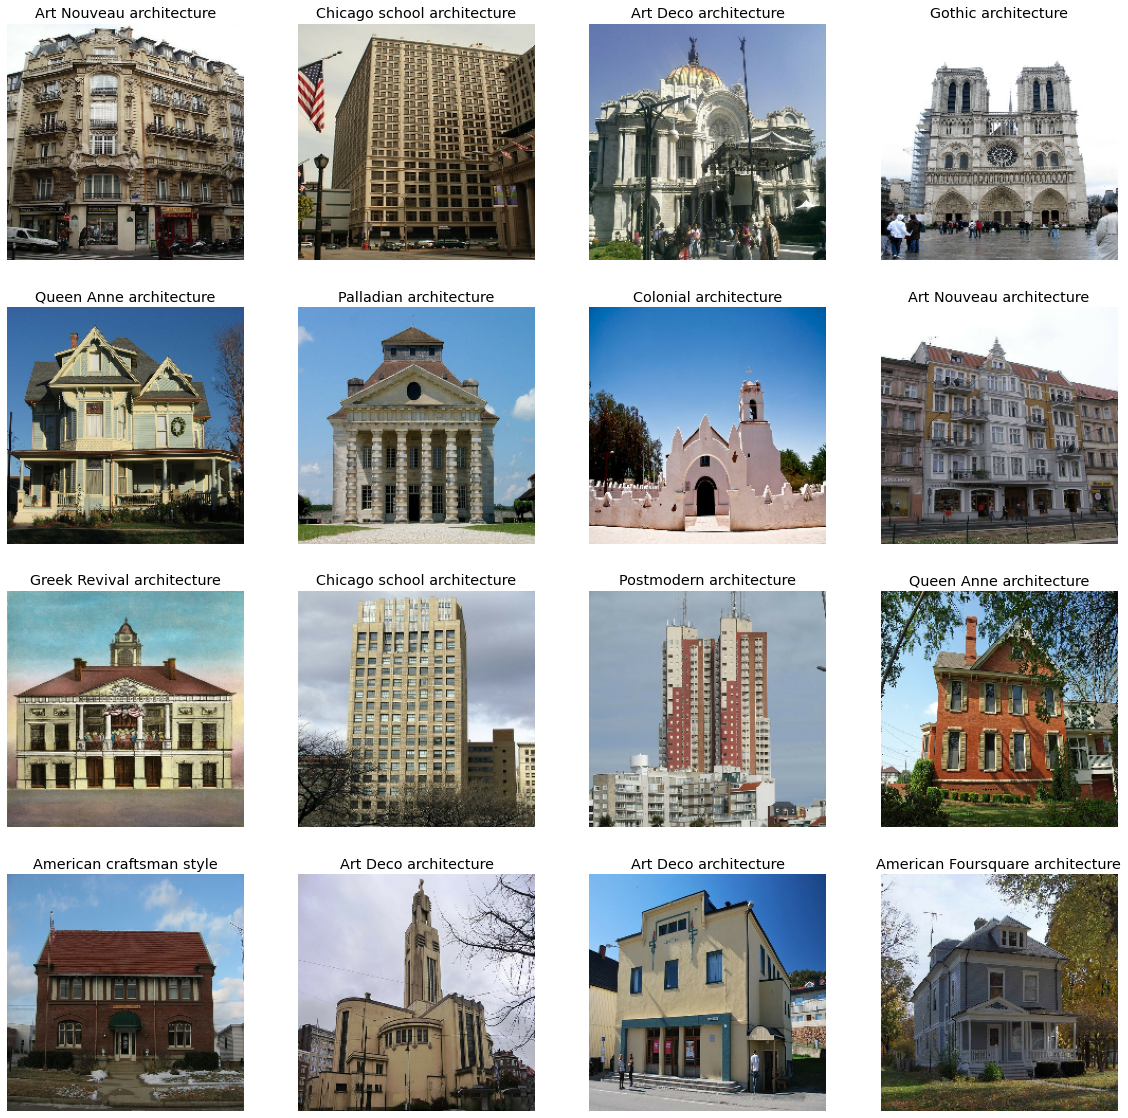

In [75]:
N_ROWS = 4
N_COLS = 4

fig, ax = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(20, 20))

for images, targets in train_ds.take(1):
    images = images.numpy().astype("uint8")
    for i in range(N_ROWS):
        for j in range(N_COLS):
            ax[i, j].set_title(id2class[targets[i * N_COLS + j]])
            ax[i, j].imshow(images[i * N_COLS + j])
            ax[i, j].axis("off")
plt.show()

#Model 1

In [251]:
i = tf.keras.layers.Input([224, 224, 3], dtype=tf.float32)
x = tf.keras.applications.resnet50.preprocess_input(i)
backbone = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')
backbone.trainable = False
x = backbone(x)
x = tf.keras.layers.Conv2D(filters=50, kernel_size=3, padding="same", activation="sigmoid")(x)
x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(units=len(id2class), activation="sigmoid")(x)
model = tf.keras.Model(inputs=[i], outputs=[x])

In [252]:
for layer in backbone.layers[-20:]:
  if layer.name == 'conv5_block3_3_conv':
    layer.trainable=True

In [253]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=tf.keras.metrics.SparseCategoricalAccuracy(name='sca')
    #metrics=tf.keras.metrics.AUC(name='auc')
)

In [254]:
#history = model.fit(train_ds, validation_data=val_ds, epochs=30)

In [255]:
class MetricsCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, metrics_name):
        super().__init__()
        self.loss = []
        self.val_loss = []
        self.metrics = []
        self.val_metrics = []
        self.metrics_name = metrics_name

    def on_epoch_end(self, epoch, logs=None):
        
        self.loss.append(logs["loss"])
        self.val_loss.append(logs["val_loss"])
        self.metrics.append(logs[self.metrics_name])
        self.val_metrics.append(logs[f"val_{self.metrics_name}"])
        
        clear_output(wait=True)
        
        plt.figure(figsize=(12,5))
        plt.subplot(121)
        plt.plot(self.loss, label="loss")
        plt.plot(self.val_loss, label="val_loss")
        plt.legend()

        plt.subplot(122)
        plt.plot(self.metrics, label=self.metrics_name)
        plt.plot(self.val_metrics, label=f"val_{self.metrics_name}")
        plt.legend()
        plt.show()

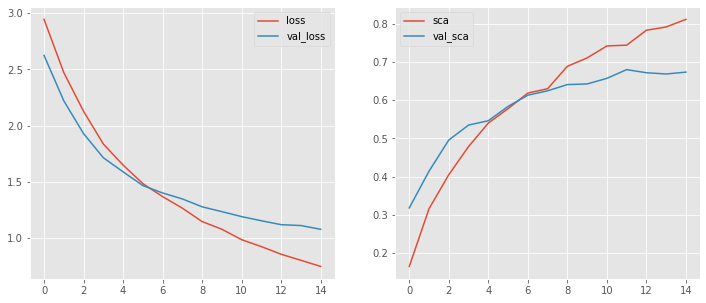

154/154 [==============================] - 22s 145ms/step - loss: 0.7490 - sca: 0.8119 - val_loss: 1.0791 - val_sca: 0.6737


In [256]:
from IPython.core.display import clear_output
history_m = model.fit(
    train_ds, validation_data=val_ds, epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10),
        tf.keras.callbacks.ReduceLROnPlateau(),
        MetricsCallback(metrics_name="sca")
    ]
)

# Validation Errors

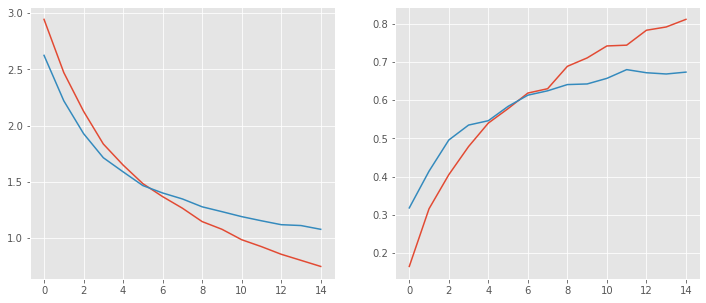

In [257]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(history_m.history["loss"], label="train")
plt.plot(history_m.history["val_loss"], label="val")
plt.subplot(122)
plt.plot(history_m.history["sca"], label="train")
plt.plot(history_m.history["val_sca"], label="val")
plt.show()

In [258]:
true_labels = []
predicted_labels = []

for batch, labels in val_ds:
  true_labels.append(labels.numpy())
  predicted_labels.append(tf.argmax(model(batch), axis=1).numpy())

In [259]:
true_labels = np.hstack(true_labels)
predicted_labels = np.hstack(predicted_labels)

In [260]:
conf_mat = confusion_matrix(true_labels, predicted_labels)

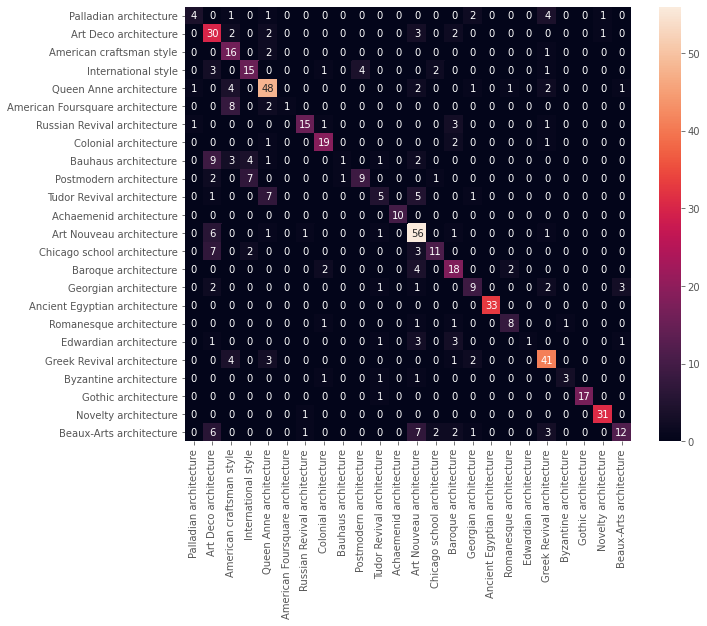

In [261]:
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, xticklabels=id2class, yticklabels=id2class, annot=True)

# Submit

In [206]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory="./data/test",
    image_size=image_size,
    batch_size=batch_size,
    shuffle=False
)

Found 1512 files belonging to 1 classes.


In [207]:
file_ids = [os.path.splitext(filename)[0] for filename in sorted(os.listdir('./data/test/test'))]

predictions = np.hstack([
  tf.argmax(model(batch), axis=1).numpy()
  for batch, _ in test_ds
])

In [208]:
submit = pd.DataFrame({"Id": file_ids, "Category": predictions})

In [209]:
submit.to_csv("mi.csv", index=False)

In [210]:
!head mi.csv

Id,Category
0,16
1,12
10,19
100,22
1000,12
1001,22
1002,12
1003,12
1004,22


In [211]:
from google.colab import files

files.download("mi.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>